In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift

In [4]:
fs = 8000 # sample/s

In [5]:
class CIC:

    def __init__(self, M, N, fs):
        self.M = M
        self.N = N
        self.fs = fs
        self.Hintegrator = self.integrator()
        self.Hcomb = self.comb()
        
    def __str__(self):
        return f"M: {self.N}, N: {self.N}, fs: {self.fs}"
    
    def __repr__(self):
        return self.__str__()

    def integrator(self):
        return signal.TransferFunction([1, 0], [1, -1], dt=1/self.fs)

    def comb(self):
        num = np.zeros(self.N + 1)
        den = np.zeros(self.N + 1)
        num[0] = 1
        num[-1] = -1
        den[0] = 1
        return signal.TransferFunction(num, den, dt=self.N/self.fs)
    
    def integrate(self, values):
        for _ in range(self.M):
            values = signal.lfilter(self.Hintegrator.num, self.Hintegrator.den, values)
        return values
    
    def downsample(self, values):
        return values[::self.N]

    def differentiate(self, values):
        for _ in range(self.M):
            values = signal.lfilter(self.Hcomb.num, self.Hcomb.den, values)
        return values

    def response(self, w):
        z_n = np.exp(-1j * w * self.N)
        z = np.exp(-1j * w)
        H = (1 - z_n) / (1 - z)
        return np.power(H / (2 ** self.N), self.M)
    
    def cic(self, values):
        return self.differentiate(self.downsample(self.integrate(values)))

In [6]:
downsampler = CIC(1, 8, 8000)
length = 10000 * 2

## Floating Point Signals

In [7]:
Ω = 10 ** np.linspace(0, 4, 1000)
attenuation = np.array([])
for i in Ω:
    x = np.sin(np.linspace(0, i * 2 * np.pi, length))
    y = downsampler.cic(x)
    attenuation = np.append(attenuation, 20 * np.log10(np.ptp(y)/np.ptp(x)))

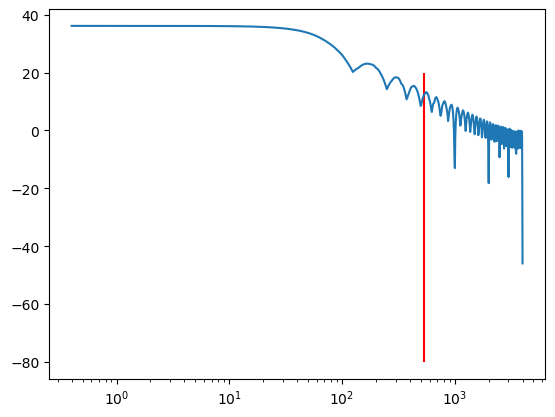

In [8]:
ω = 2 * np.pi * downsampler.fs * Ω / 10000 / 2
f = ω / 2 / np.pi 
plt.semilogx(f, attenuation)
plt.vlines([np.argmin(np.abs(attenuation - max(attenuation) + 3))], ymax = 20, ymin = -80, color="red")

## Noisy Floating Point Signals

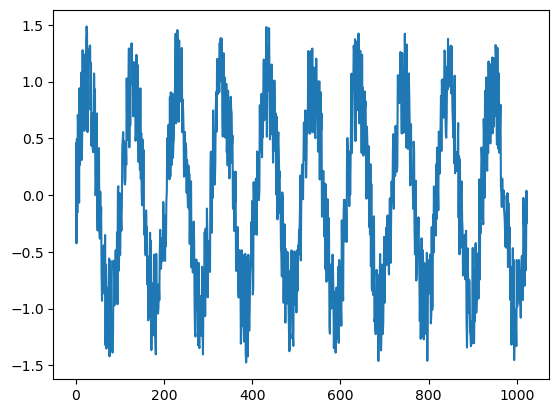

In [9]:
noisy = np.sin(np.linspace(0, 2 * np.pi * 10, 1024)) + np.random.rand(1024) - 0.5
plt.plot(noisy)

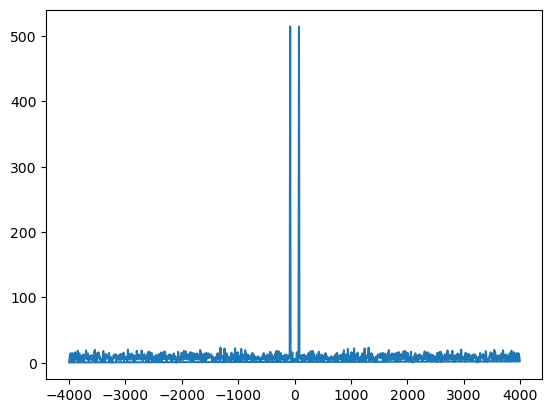

In [10]:
freqs = fftfreq(len(noisy), d=1/downsampler.fs)
fft_noisy = fft(noisy)
plt.plot(freqs, np.abs(fft_noisy))

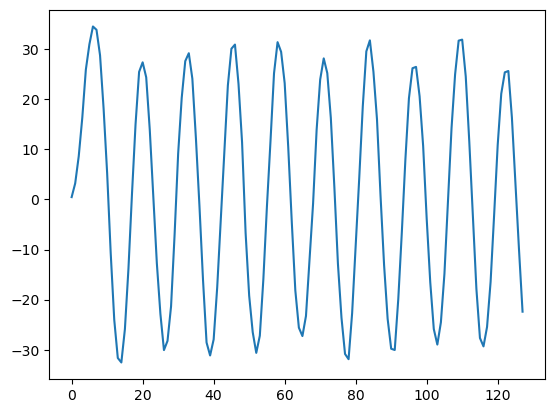

In [11]:
reconstructed = downsampler.cic(noisy)
plt.plot(reconstructed)

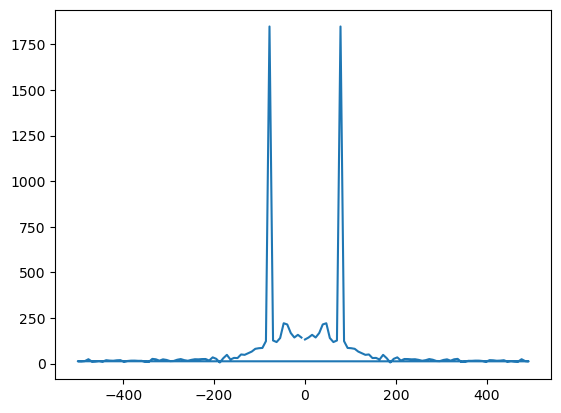

In [12]:
freqs_clean = fftfreq(len(reconstructed), d=downsampler.N/downsampler.fs)
fft_clean = fft(reconstructed)
plt.plot(freqs_clean, np.abs(fft_clean))

## Digital 10-bit Signal

In [13]:
(2 ** 9 - 1) + (2 ** 9 - 1)
np.log2((2 ** 9 - 1) + (2 ** 9 - 1))

9.997179480937621

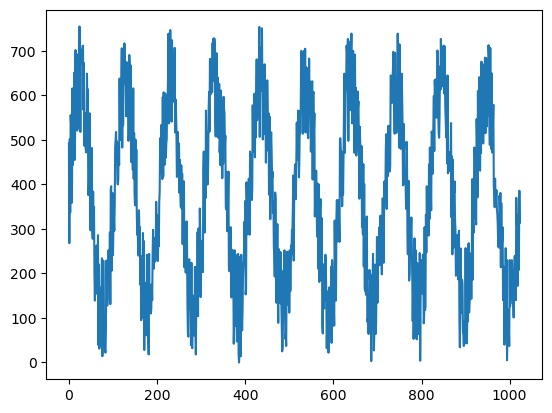

In [14]:
noisy_scaled = noisy * (2 ** 8 - 1)
noisy_quantized = np.round(noisy_scaled)
noisy_digital = noisy_quantized - min(noisy_quantized)
plt.plot(noisy_digital)

In [15]:
qe = np.sqrt(np.mean((noisy_scaled - noisy_quantized) ** 2))
qe

0.2838922281907328

In [16]:
bits = np.ceil(np.log2(max(noisy_digital)))
bits

10.0

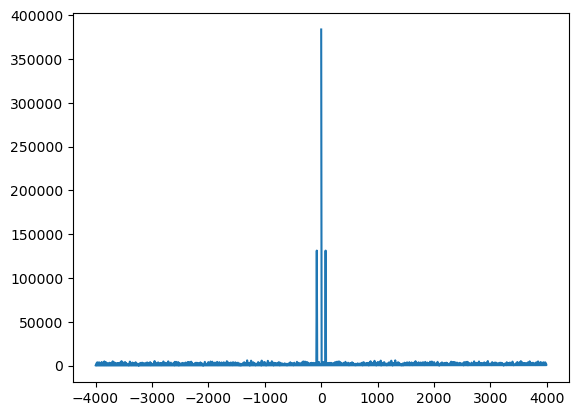

In [17]:
freqs_noisy_digital = fftfreq(len(noisy_digital), d=1/downsampler.fs)
fft_noisy_digital = fft(noisy_digital)
plt.plot(freqs_noisy_digital, np.abs(fft_noisy_digital))

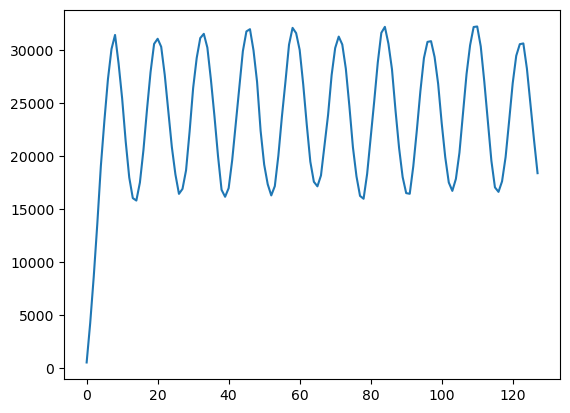

In [18]:
reconstructed_digital = downsampler.cic(noisy_digital)
plt.plot(reconstructed_digital)

In [19]:
bits = np.ceil(np.log2(max(reconstructed_digital)))
bits

15.0

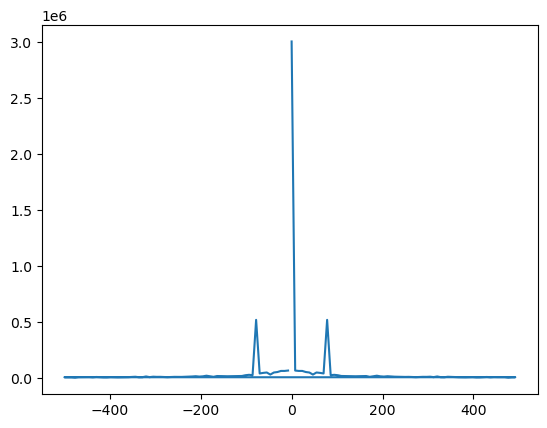

In [20]:
freqs_digital_clean = fftfreq(len(reconstructed_digital), d=downsampler.N/downsampler.fs)
fft_digital_clean = fft(reconstructed_digital)
plt.plot(freqs_digital_clean, np.abs(fft_digital_clean))

## Optimizing N

## Visualization of $N = 8$  Decimation

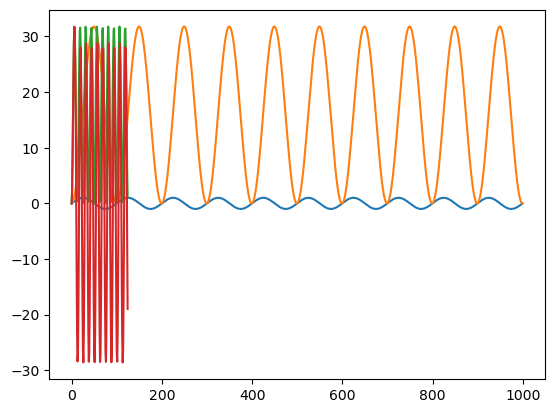

In [21]:
x = np.sin(np.linspace(0, 2 * np.pi * 10, 1000))
plt.plot(x)

y = downsampler.integrate(x)
plt.plot(y)

z = downsampler.downsample(y)
plt.plot(z)

a = downsampler.differentiate(z)
plt.plot(a)

## Visualizing Frequency Response

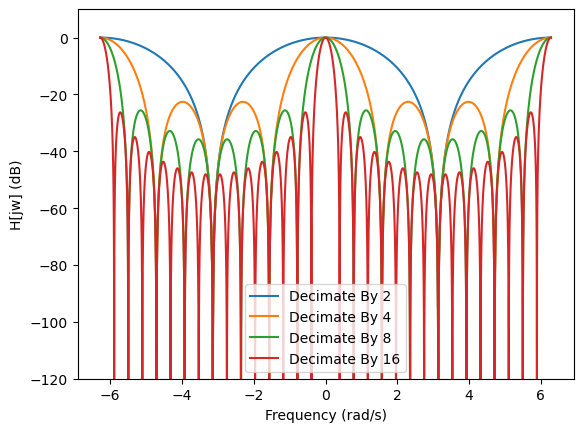

In [22]:
def get_decimated_response(order: int, factor: int, w: np.ndarray) -> np.ndarray:
    """
    Calculate the total decimated response of a CIC filter.
    The filter is of order `order` and assumed to down sample by a factor 
    `factor`.
    """
    pass

w = np.linspace(-2 * np.pi, 2 * np.pi, 100000)
for i in [2, 4, 8, 16]:
    downsampler = CIC(2, i, 8000)
    resp = downsampler.response(w)
    mag = np.abs(resp)
    mag = mag / max(mag)
    plt.plot(w, 20*np.log10(mag), label=f"Decimate By {i}")
plt.legend()
plt.xlabel("Frequency (rad/s)")
plt.ylabel("H[jw] (dB)")
plt.ylim(-120, 10)

plt.show()

# Calculating the energy of downsampled components

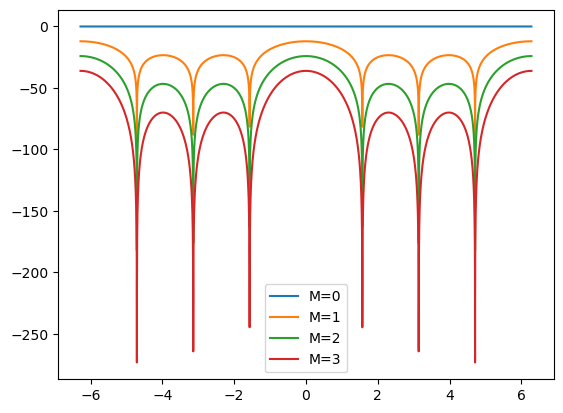

In [23]:
w = np.linspace(-2 * np.pi, 2 * np.pi, 10000)
n = 4
for m in np.arange(4):
    downsampler = CIC(m, n, 8000)
    response = downsampler.response(w)
    mag = np.abs(response)
    plt.plot(w, 20 * np.log10(mag), label=f"M={m}")
plt.legend()

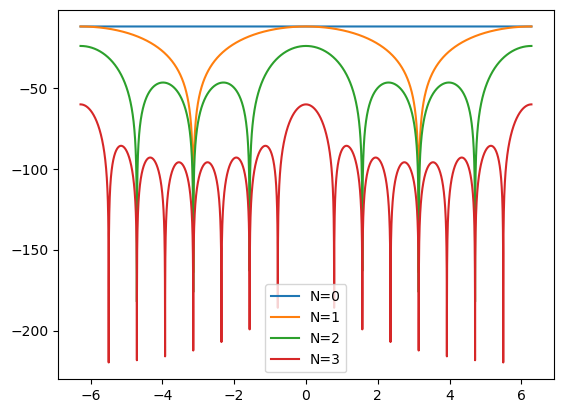

In [24]:
m = 2
for n in np.arange(4):
    downsampler = CIC(m, 2 ** n, 8000)
    response = downsampler.response(w)
    mag = np.abs(response)
    plt.plot(w, 20 * np.log10(mag), label=f"N={n}")
plt.legend()

In [25]:
def aliasing(N, w, Xplus, step, plot=False):
    energy = 0
    logs = np.arange(1, N + 1)
    offsets = 2 * np.pi * logs - np.pi / np.flip(logs)
    indexes = np.round(offsets / step).astype(int)
    dxi = int(np.pi / (2 ** N) / step)
    for offset in indexes:
        energy += np.trapz(Xplus[offset:offset+dxi+1], w[offset:offset+dxi+1])
    Xplus_dB = 20 * np.log10(Xplus)
    if plot:
        plt.plot(w, Xplus)
        plt.vlines(offsets, ymin=min(Xplus), ymax=max(Xplus), color="red")
        plt.vlines(offsets + np.pi / (2 ** N), ymin=min(Xplus), ymax=max(Xplus), color="green")
        plt.show()
    return 2 * energy # Account for symmetry

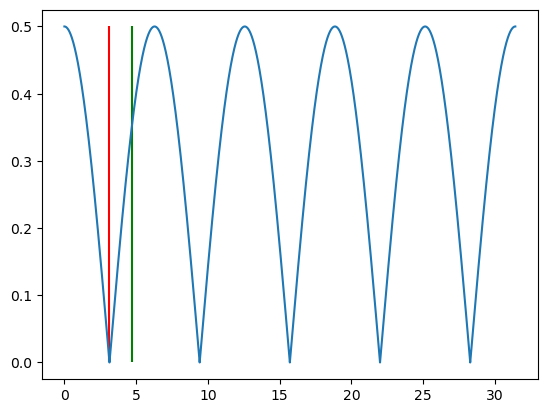

M = 1, N = 1, energy = 0.5858197585240151


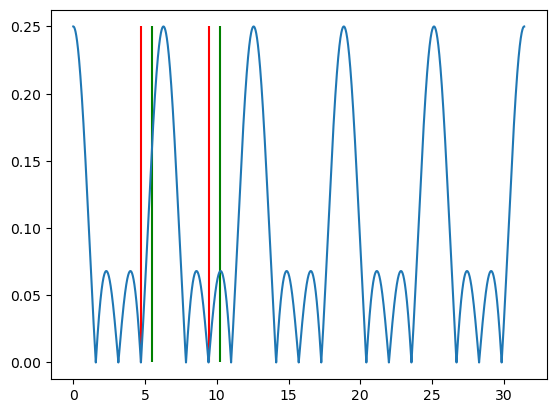

M = 1, N = 2, energy = 0.19094051373182194


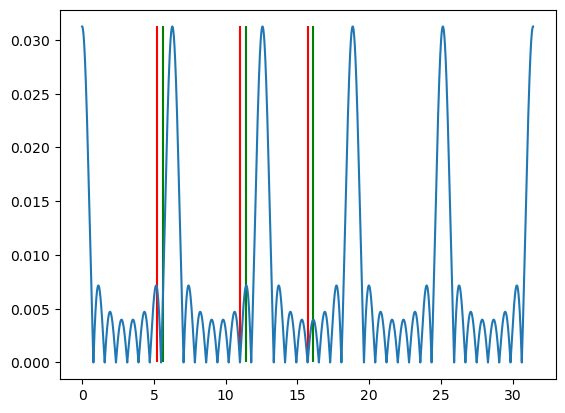

M = 1, N = 3, energy = 0.008069103611873976


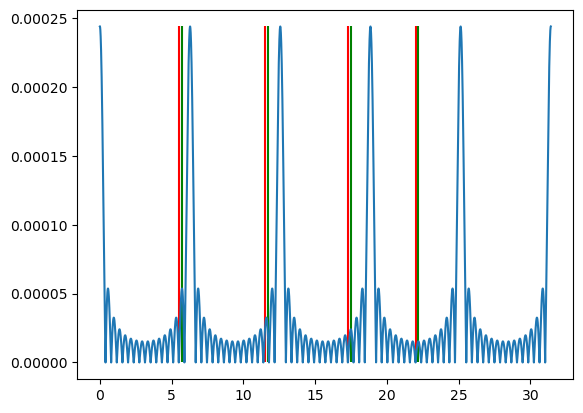

M = 1, N = 4, energy = 3.2796376693642495e-05


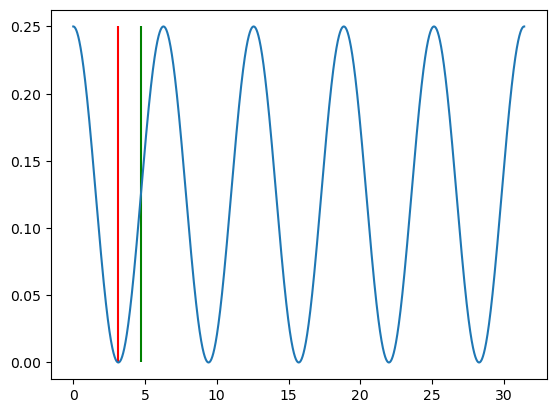

M = 2, N = 1, energy = 0.14271086512292963


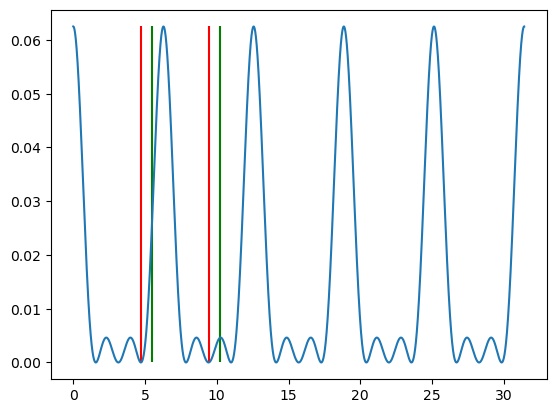

M = 2, N = 2, energy = 0.01710096428669787


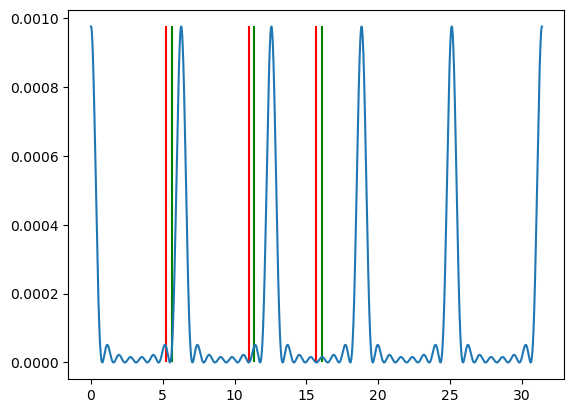

M = 2, N = 3, energy = 3.655193227970086e-05


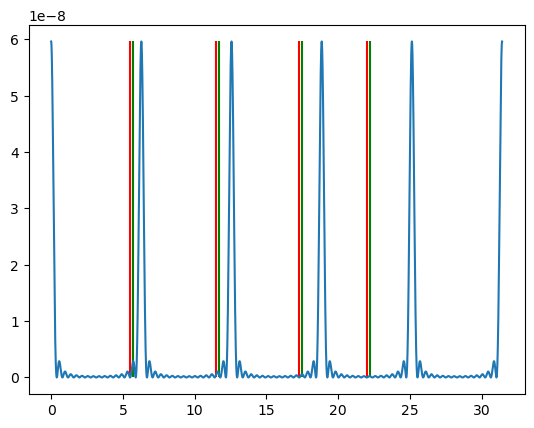

M = 2, N = 4, energy = 9.433910931145868e-10


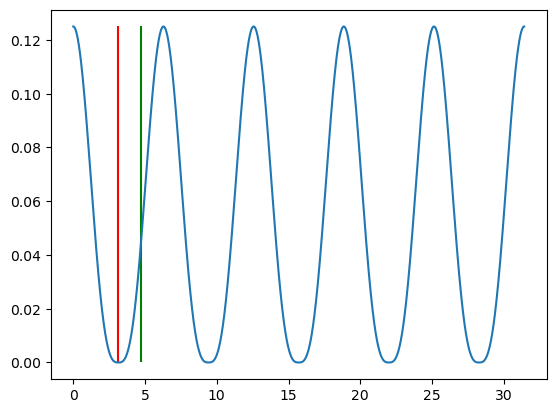

M = 3, N = 1, energy = 0.038709674321130226


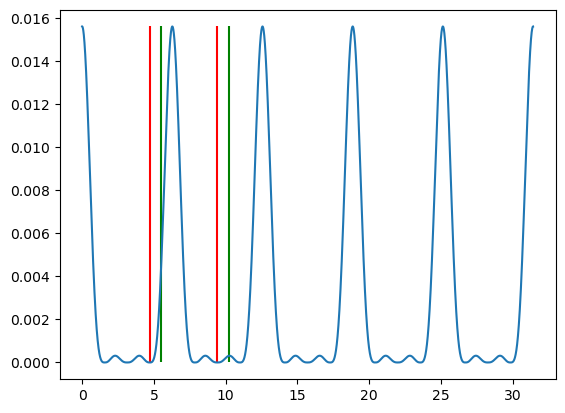

M = 3, N = 2, energy = 0.0018817284699142907


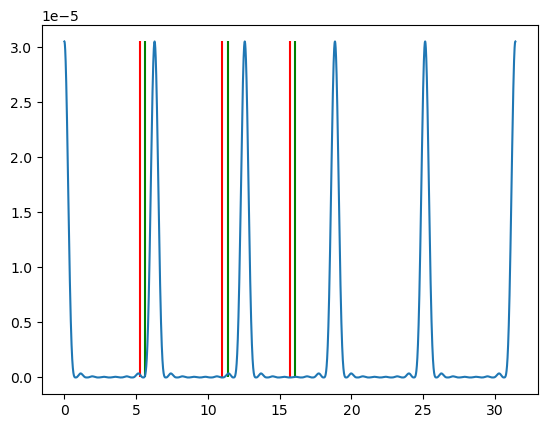

M = 3, N = 3, energy = 1.8808003327180635e-07


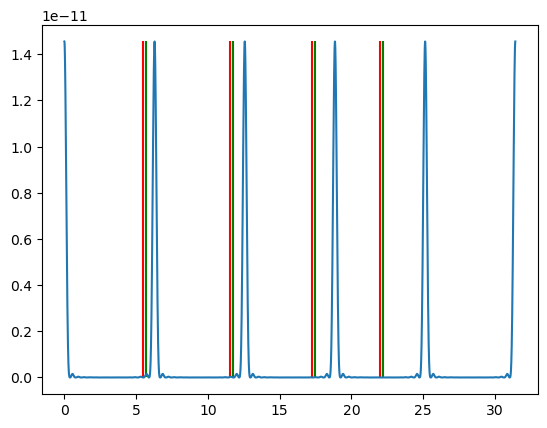

M = 3, N = 4, energy = 3.207917628641887e-14


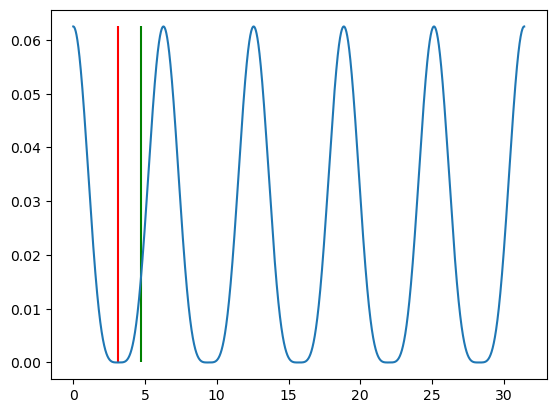

M = 4, N = 1, energy = 0.011132551038294625


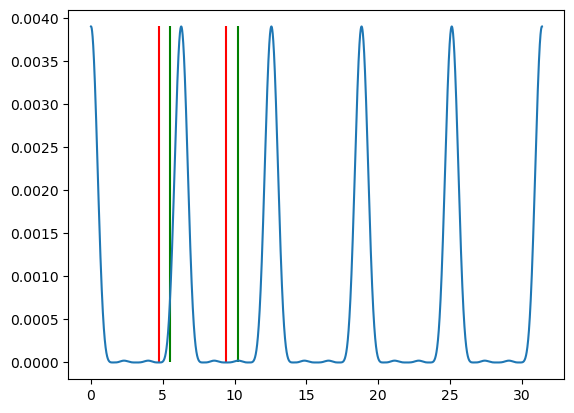

M = 4, N = 2, energy = 0.000233578087702922


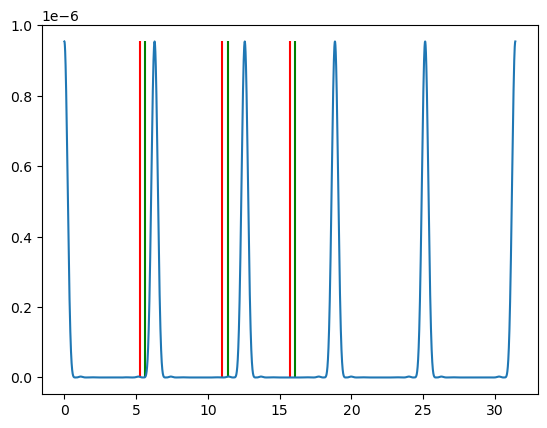

M = 4, N = 3, energy = 1.0438717458871986e-09


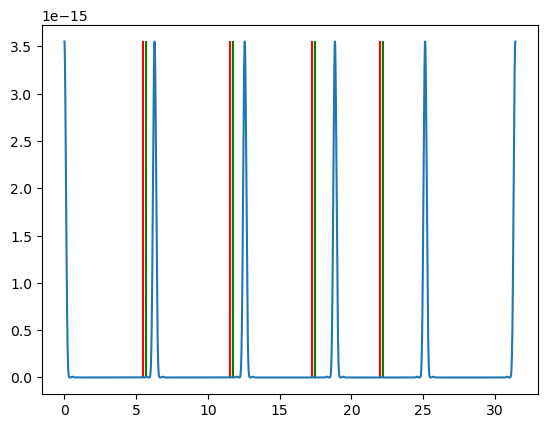

M = 4, N = 4, energy = 1.2175789288289447e-18


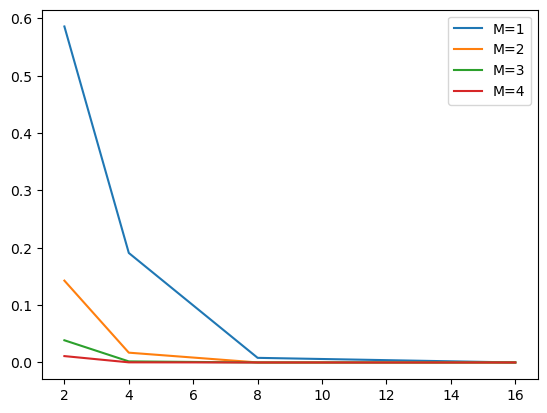

In [26]:
w = np.linspace(1e-12, 10 * np.pi, 100000)
M = np.arange(1, 5)
N = np.arange(1, 5)
energies = np.zeros((len(M), len(N)))
for i, m in enumerate(M):
    for j, n in enumerate(N):
        downsampler = CIC(m, 2 ** n, 8000)
        response = downsampler.response(w)
        mag = np.abs(response)
        aliased = aliasing(n, w, mag, 10 * np.pi / 100000, plot=True)
        print(f"M = {m}, N = {n}, energy = {aliased}")
        energies[i, j] = aliased
for i, Nenergies in enumerate(energies):
    plt.plot(2 ** N, Nenergies, label=f"M={M[i]}")
plt.legend()
plt.show()

/var/folders/lh/d83mzpk95pn5tpmd9qkgcqk80000gn/T/ipykernel_85133/2471566211.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(M, 20 * np.log10(Menergies), label=f"N={N[i]}")


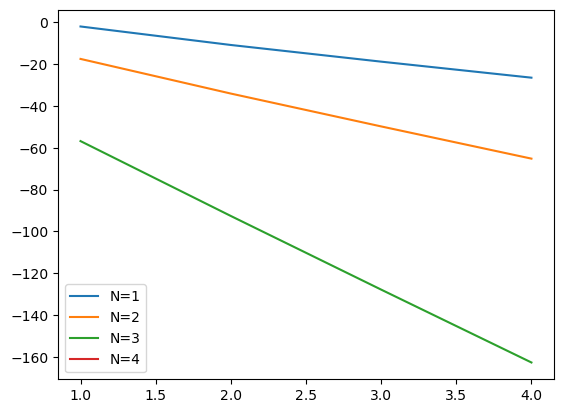

In [27]:
ω = np.linspace(1e-12, 10 * np.pi, 100000)
M = np.arange(1, 5)
N = np.arange(1, 5)
energies = np.zeros((len(N), len(M)))
for i, n in enumerate(N):
    for j, m in enumerate(M):
        downsampler = CIC(m, 2 ** n, 8000)
        response = downsampler.response(w)
        mag = np.abs(response)
        aliased = aliasing(2 ** n, w, mag, 10 * np.pi / 100000, plot=False)
        energies[i, j] = aliased
for i, Menergies in enumerate(energies):
    plt.plot(M, 20 * np.log10(Menergies), label=f"N={N[i]}")
plt.legend()
plt.show()

In [28]:
energies

array([[8.01144176e-01, 2.89164852e-01, 1.15458314e-01, 4.77465384e-02],
       [1.34204846e-01, 1.99017691e-02, 3.25887996e-03, 5.52448660e-04],
       [1.45091398e-03, 2.34711212e-05, 4.06620319e-07, 7.34001276e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# Python Implementation

In [29]:
class CIC_float(CIC):
    
    def __init__(self, M, N, fs):
        super().__init__(M, N, fs)
    
    def integrate(self, values):
        """
        Mutates input array values
        """
        buffer = 0
        for i in range(len(values)):
            values[i] = values[i] + buffer
            buffer = values[i]
        return values
    
    def downsample(self, values):
        return values[::N]
    
    def differentiate(self, values):
        buffer = [0] * self.N
        temp = 0
        index = 0

        for i in range(len(values)):
            temp = values[i]
            values[i] = values[i] - buffer[index]
            buffer[index] = temp
            index = (index + 1) % self.N
        
        return values

In [186]:
class CIC_int(CIC):
    
    def __init__(self, M, N, fs, bits):
        super().__init__(M, N, fs)
        self.bits = bits
    
    def integrate(self, values):
        """
        Mutates input array values
        """
        buffer = 0
        for i in range(len(values)):
            values[i] = (values[i] + buffer)
            buffer = values[i]
        return values
    
    def downsample(self, values):
        return values[::self.N]
    
    def differentiate(self, values):
        buffer = [0 for i in range(self.N)]
        temp = 0

        for i in range(len(values)):
            temp = values[i]
            values[i] = values[i] - buffer[i % self.N]
            buffer[i % self.N] = temp
        
        return values

## Verilog testing

In [187]:
DUT = CIC(1, 2, 8000)
DUT_int = CIC_int(1, 2, 8000, 10)

In [237]:
wave = np.sin(np.linspace(0, 2 * np.pi, 1024)) + np.random.rand(1024)
counts = np.clip(np.int_(np.ceil((wave * (2 ** 9)))) + 511, 0, 1023)

In [238]:
with open("inputs.txt", "w+") as f:
    for count in counts:
        f.write(str(count) + "\n")

In [239]:
with open("outputs.txt", "r+") as f:
    downsampled = np.fromstring(f.read(), sep="\n")

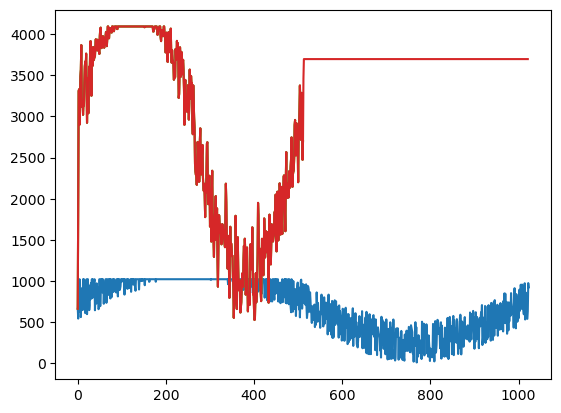

In [240]:
plt.plot(counts.copy())
plt.plot(DUT_int.cic(counts.copy()))
plt.plot(DUT.cic(counts.copy()))
plt.plot(downsampled)

In [236]:
DUT_int.integrate(counts.copy())[10:20]

array([ 9090,  9921, 10586, 11259, 12302, 13002, 13723, 14321, 15023,
       15949])